# **SkinCancerClasification - With Scaling and more Optimisations**


## **Import libraries, read dataset**

In [1]:
# Import our dependencies
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import tensorflow as tf
# Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
# Sklearn scaling
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('https://mlee22ph.github.io/Project4_Group11_AR_GP_ML/Resources/hmnist_28_28_RGB.csv')
data.head()

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

In [3]:
y = data['label']
x = data.drop(columns = ['label'])

In [4]:
tabular_data = pd.read_csv('https://mlee22ph.github.io/Project4_Group11_AR_GP_ML/Resources/HAM10000_metadata.csv')
tabular_data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [5]:
tabular_data.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [6]:
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'),
           1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}


## **Model Analysis and Prediction**

In [7]:
x.shape

(10015, 2352)

In [8]:
y.shape

(10015,)

### **Use RandomOverSampler**

In [9]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [10]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


In [11]:
print('Shape of Y :',y.shape)

Shape of Y : (46935,)


### **Standardization and Splitting Data**

In [12]:
x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [13]:
X_train.shape

(37548, 28, 28, 3)

In [14]:
# We want to flatten our image of 28x28 pixels to a 1D array of 784 pixels
ndims = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
X_train = X_train.reshape(X_train.shape[0], ndims)
X_test = X_test.reshape(X_test.shape[0], ndims)
print("Training Shape:", X_train.shape)
print("Testing Shape:", X_test.shape)

Training Shape: (37548, 2352)
Testing Shape: (9387, 2352)


### **Scaling and Normalization**

In [15]:
# Next, we normalize our training data to be between 0 and 1
scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### **Create Sequential Model**

**With 64 units:**

294/294 - 1s - loss: 0.9814 - accuracy: 0.6068 - 926ms/epoch - 3ms/step
Loss: 0.9813539981842041, Accuracy: 0.6067966222763062

In [16]:
# Increased units from previous try
num_classes = 100

# Create an empty sequential model
model = Sequential()
# Add the first layer where the input dimensions are the 784 pixel values
# We can also choose our activation function. `relu` is a common
model.add(Dense(num_classes, activation='relu', input_dim=X_train.shape[1]))
# Add a second hidden layer
model.add(Dense(num_classes, activation='relu'))
# Add our final output layer where the number of nodes
# corresponds to the number of y labels
model.add(Dense(7, activation='softmax'))

In [17]:
# We can summarize our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               235300    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 7)                 707       
                                                                 
Total params: 246107 (961.36 KB)
Trainable params: 246107 (961.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### **Compile Model using sparse_categorical_crossentropy, meaning no need for One Hot Encoding**

In [18]:
# Sparse categorical cross-entropy is an extension of the categorical cross-entropy loss function that is used when the output labels are represented in a sparse matrix format.
# In a sparse matrix format, the labels are represented as a single index value rather than a one-hot encoded vector. This means that the labels are integers rather than vectors.
# Both categorical cross-entropy and sparse categorical cross-entropy have the same loss function as defined above. The only difference between the two is in how labels are defined.
# Hint: your output layer in this example is using software for logistic regression (categorical)
# If your output layer activation was `linear` then you may want to use `mse` for loss
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# Increased epochs to 100
# Fit (train) the model
history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    shuffle=True,
    verbose=2
)

Epoch 1/100
1174/1174 - 6s - loss: 1.6337 - accuracy: 0.3550 - 6s/epoch - 5ms/step
Epoch 2/100
1174/1174 - 6s - loss: 1.3746 - accuracy: 0.4644 - 6s/epoch - 5ms/step
Epoch 3/100
1174/1174 - 6s - loss: 1.2507 - accuracy: 0.5174 - 6s/epoch - 5ms/step
Epoch 4/100
1174/1174 - 6s - loss: 1.1642 - accuracy: 0.5525 - 6s/epoch - 5ms/step
Epoch 5/100
1174/1174 - 6s - loss: 1.0963 - accuracy: 0.5815 - 6s/epoch - 5ms/step
Epoch 6/100
1174/1174 - 5s - loss: 1.0277 - accuracy: 0.6088 - 5s/epoch - 4ms/step
Epoch 7/100
1174/1174 - 7s - loss: 0.9838 - accuracy: 0.6259 - 7s/epoch - 6ms/step
Epoch 8/100
1174/1174 - 5s - loss: 0.9356 - accuracy: 0.6464 - 5s/epoch - 4ms/step
Epoch 9/100
1174/1174 - 7s - loss: 0.8901 - accuracy: 0.6635 - 7s/epoch - 6ms/step
Epoch 10/100
1174/1174 - 5s - loss: 0.8435 - accuracy: 0.6832 - 5s/epoch - 4ms/step
Epoch 11/100
1174/1174 - 7s - loss: 0.8121 - accuracy: 0.6943 - 7s/epoch - 6ms/step
Epoch 12/100
1174/1174 - 5s - loss: 0.7843 - accuracy: 0.7057 - 5s/epoch - 4ms/step
E

In [20]:
# Evaluate the model using the training data
model_loss, model_accuracy = model.evaluate(X_test, Y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

294/294 - 1s - loss: 0.3473 - accuracy: 0.8795 - 831ms/epoch - 3ms/step
Loss: 0.3472852408885956, Accuracy: 0.879514217376709


## **Making Predictions and Classification Report**

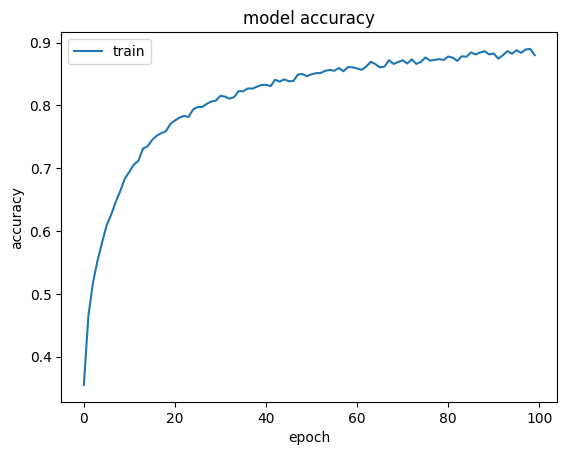

In [21]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
y_true = np.array(Y_test)
y_pred = model.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
print(y_true)
print(y_pred)

294/294 [==============================] - 1s 2ms/step
[5 1 4 ... 2 6 0]
[5 1 4 ... 0 6 0]


In [23]:
pred=model.predict(X_test)
pred

294/294 [==============================] - 1s 3ms/step


array([[4.66845618e-10, 2.52161735e-05, 1.77231419e-03, ...,
        5.03356932e-05, 9.98144984e-01, 7.13741747e-06],
       [3.72589479e-04, 9.88827169e-01, 1.12193299e-03, ...,
        1.31994957e-05, 8.19875723e-09, 5.64251764e-07],
       [4.46647317e-14, 1.04817049e-11, 4.76469402e-04, ...,
        9.99511302e-01, 1.28728645e-22, 1.21608718e-05],
       ...,
       [6.31309450e-01, 9.14372413e-06, 8.48620906e-02, ...,
        4.20503840e-02, 1.13386252e-10, 2.41768956e-01],
       [4.45514132e-08, 1.03915127e-05, 1.02425724e-01, ...,
        1.79821048e-02, 1.44939533e-36, 8.79581749e-01],
       [9.37102377e-01, 5.92554919e-02, 2.01503932e-03, ...,
        1.01722218e-03, 1.18979401e-11, 5.39022440e-04]], dtype=float32)

In [24]:
from sklearn.metrics import confusion_matrix , classification_report

target_names = ["akiec", "bcc", "bkl", "df", "nv", "vasc", "mel"]
report = classification_report(y_true, y_pred, target_names=target_names)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.91      1.00      0.95      1359
         bcc       0.88      0.97      0.92      1318
         bkl       0.84      0.67      0.74      1262
          df       0.98      1.00      0.99      1351
          nv       0.78      0.71      0.75      1374
        vasc       1.00      0.99      1.00      1358
         mel       0.76      0.81      0.78      1365

    accuracy                           0.88      9387
   macro avg       0.88      0.88      0.88      9387
weighted avg       0.88      0.88      0.88      9387



In [ ]:
# Grab just one data point to test with
test = np.expand_dims(X_train[0], axis=0)
test.shape

(1, 2352)

## **Saving and Loading models**

In [25]:
# Save the model
model.save("SkinCancerClasificationWithScalingMoreOptimisations.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the model
from tensorflow.keras.models import load_model
model = load_model("SkinCancerClasificationWithScalingMoreOptimisations.h5")